# PROBLEM STATEMENT
Opinion Mining is a text analysis technique that automatically mines text for opinion and emotion. For example, a tweet “Bought a Huawei p30 pro yesterday and found the camera terrific” contains a positive opinion towards Huawei p30 pro camera. This could be formalized as a multi-output machine learning task of Named Entity Recognition (NER) and Text Classification. Please refer to more examples in the table below.

Formalization:

Sentence ｜ NER Tag ｜ Class｜

Bought a Huawei p30 pro and found the camera terrific. ｜Product, Part ｜Positive｜

My friend plans to fix his old Huawei p20 phone. ｜Product｜ Neutral｜

Mic of that phone easily goes faulty. ｜Part｜ Negative｜

You are going to be challenged on a complete project. Use the subtasks below as the basis of your implementation.

# Problem Understanding

This task focuses on Opinion Mining, which involves extracting opinions, sentiments, and specific entities from text data. The goal is to identify not only the sentiment (positive, neutral, negative) expressed in the text but also to recognize specific products or parts of products mentioned. This problem can be framed as a multi-output machine learning task combining: **Named Entity Recognition (NER)** and **Text Classification (Sentiment Analysis)**.

# Solution Design

This solution is designed to address the task of Opinion Mining by combining **Named Entity Recognition (NER)** and **Sentiment Classification** into a single model.

* Data Collection
  * generate the dataset using **GPT-3.5-turbo** models
  * **One-Shot Prompt Engineering**

* Data Preprocessing
  * Remove unnecessary characters (e.g., special symbols, excessive spaces)
  * drop duplicated data
  * remove invalid data
* Model selection
  * A BERT base model (**bert-base-uncased**) was used as the core.
  * Loss Functions
    * NER Loss: Use **CrossEntropyLoss** for token-level classification.
    * Sentiment Loss: Use **CrossEntropyLoss** for sentence-level classification.
    * The total loss is the **sum** of both losses, ensuring balanced learning between * both tasks.

* Training Strategy
  * Split the dataset into 80% training and 20% testing.

* Evaluation and Metrics
  * NER Task:
    * **Precision, Recall, and F1-Score** for each label.
    * **Confusion matrix** to visualize misclassifications between the different NER tags.
  * Sentiment Classification Task:
    * **Accuracy, Precision, Recall, and F1-Score** for the sentiment labels (Positive, Neutral, Negative).
    * Use a **confusion matrix** to understand common misclassifications between the sentiment categories.

# Question 1 - Data Research

## Create/collect a dataset of at least 1000 sentences annotated with NER tags of ‘Product’ and ‘Part’ (You can define your own NER tags per specific requirement), and class labels of ‘Positive’, ‘Neutral’ or ‘Negative’.

To tackle the first task, we can use **GPT-3.5-turbo** to generate a dataset of at least 1000 sentences that are annotated with Named Entity Recognition (NER) tags of 'Product' and 'Part' as well as class labels like 'Positive', 'Neutral', and 'Negative'. I will use a **one-shot prompt engineering** approach to guide the model in generating structured output.


When generating the data, try to simulate real-world data as much as possible by adding elements such as **emojis, special characters, extra spaces,** etc. This will ensure that the generated data requires data cleaning operations.

Although there may be some bias in the annotated data, the majority of the annotations generated by the gpt model are accurate. Therefore, we can proceed with using this data directly.



In [1]:
!pip install openai
!pip install emoji
!pip install wordcloud
!pip install tqdm
!pip install torchviz
!pip install torchsummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=b89364a91aed8e50500ba6be17230f81d388f93642959cd6d24e9f7d51d99ad5
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import openai
import csv
from openai import OpenAI
import os
from tqdm import tqdm
from torchviz import make_dot
from torchsummary import summary

In [ ]:
# OpenAI API key, it has been remove
# api_key = 'XXX'

# # prompt to generate data
# prompt = """
# Create 20 entries for data cleaning and model training in the following format:
# Sentence | NER Tag | Class
# Bought a Huawei p30 pro and found the camera terrific. | Product, Part | Positive
# My friend plans to fix his old Huawei p20 phone. | Product | Neutral
# Mic of that phone easily goes faulty. | Part | Negative

# The data includes Sentence, NER Tag, and Class parts. Sentences are related to mobile phone reviews, NER Tag will label Product if it mentions a product, Part if it mentions a product part, and both if both are mentioned. Class will label the sentiment as Positive, Neutral, or Negative.
# Make sure the generated data contains noise in the Sentence column, including variations with symbols, spaces in the middle of the sentence, emojis, and special characters (e.g., #, @, !). Output the data in a table format.

# example:
# Love the design, but the SPEAKER is terrible...😂😂🙈🙈 ｜ Part | Negative
# Phone speed - amazing. Phone features - amazing. Phone design and colour - amazing. Memory on phone - amazing. Battery life and how quickly it charges - amazing. Fingerprint scanner - amazing. In fact amazing is just an understatement. I have always loved Huawei phones since getting my first one back in Spring 2017. I will try to hold out with Huawei for as long as possible (even if it means to continuously buy pre-May 2019 phones). Literally, what more can I say? I have had this phone for 6 months and it is still going strong. I am so happy with my purchase :) ｜ Product, Part | Positive
# Mic of that phone  !  &……* @@@@ easily goes faulty. | Part | Negative
# Just got my hands on the new Samsung Galaxy S21 Ultra! 📱🔥 | Product | Positive
# This phone IS AWEEESOME FOR THE PRICE. I got the peacock blue p30 lite for £180. The phone has great battery life. I can play games and it will genuinely last for a long time (ofc will vary from people and typea of games and apps they use). The fingerprint scanner is instant! Like no lag when using it. The face rec is decent too, I prefer the fingerprint but I use both and they both good. The phone looks sexy as hell too. But its a fingerprint magnet, so buy a clear case in addition since UK models dont get cases. And oo charges really fast too. | Product, Part | Positive
# """
# client = OpenAI(api_key=api_key)
# # call OpenAI GPT API to generate data
# def generate_data(prompt):
#     response = client.chat.completions.create(
#         messages=[{"role": "user", "content": prompt}],
#         model='gpt-3.5-turbo',
#         temperature=1,
#         top_p=0.9,
#         max_tokens=1500,
#     )
#     result = response.choices[0].message.content.strip()
#     return result

# # Append the generated data to the CSV file
# def append_to_csv(filename, data):
#     file_exists = os.path.isfile(filename)
#     with open(filename, mode='a', newline='') as file:
#         writer = csv.writer(file)

#         # Write data in rows
#         for index, row in enumerate(data.split('\n')):
#             row_data = row.split(' | ')
#             if len(row_data) == 3:
#                 # If the file already exists, ignore the first row header
#                 if file_exists and index == 0:
#                     continue
#                 writer.writerow(row_data)

# if __name__ == "__main__":
#     for i in range(3):
#         generated_data = generate_data(prompt)
#         print("Generated Data:\n", generated_data)
#         append_to_csv("opinion_mining_dataset.csv", generated_data)


# Question 2:
Analyze and report about the quality and statistics of this dataset.

By reading the previously generated CSV file, we will perform data cleaning operations as follows:



*   Remove the '｜' symbol.
*   Update the column names.
*   Check for duplicate entries and remove any duplicates.
*   Add two new columns, 'Symbols Count' and 'Emoji Count', to display the count of special characters and emojis for each sentence.
*   Remove rows where the 'NER Tag' column contains values outside of 'Product', 'Part', or 'Product, Part', and remove rows where the 'Class' column contains values outside of 'Positive', 'Neutral', or 'Negative'.
*   Analyze and report about the quality and statistics.
*   Data visualisation








In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from wordcloud import WordCloud
import string
import nltk # Natural Language tool kit
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import emoji
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

## Remove the '｜' symbol.

In [4]:
# read data from csv
df = pd.read_csv('opinion_mining_dataset.csv', sep=',', skipinitialspace=True)

In [5]:
# remove | and space
df_remove_noise = df.applymap(lambda x: x.replace('|', '').strip())

<ipython-input-5-f6a7ae6197fe>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_remove_noise = df.applymap(lambda x: x.replace('|', '').strip())


In [6]:
df_remove_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 3 columns):
 #   Column                                                           Non-Null Count  Dtype 
---  ------                                                           --------------  ----- 
 0   | Sentence                                                       1373 non-null   object
 1   NER Tag                                                          1373 non-null   object
 2   Class    |                                                       1373 non-null   object
dtypes: object(3)
memory usage: 32.3+ KB


In [7]:
# Inorder to update the column name, get the original column name
df_remove_noise.columns

Index(['| Sentence                                                     ',
       'NER Tag        ', 'Class    |'],
      dtype='object')

## Update the column names.

In [8]:
df_update_column=df_remove_noise.rename(columns={'| Sentence                                                     ': 'Sentence', 'NER Tag        ': 'NER Tag', 'Class    |': 'Class'})
df_update_column

,Sentence,NER Tag,Class
0,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive
1,My friend plans to fix his old Huawei P20 phone.,Product,Neutral
2,Mic of that phone easily goes faulty.,Part,Negative
3,The battery life of my iPhone XR is amazing!,"Product, Part",Positive
4,I can't stand the slow performance of my Samsu...,"Product, Part",Negative
...,...,...,...
1368,Loving the new design of the OnePlus Nord N10 ...,Product,Positive
1369,The battery life of the Google Pixel 4a 5G is ...,"Product, Part",Positive
1370,The camera settings on the Vivo X50 Pro are co...,"Product, Part",Negative
1371,The sound quality of the Huawei Mate 40 Pro is...,"Product, Part",Positive


## Check for duplicate entries and remove any duplicates.

In [9]:
# Gets the number of duplicates for each data
df_update_column[df_update_column.duplicated(keep=False)].groupby(list(df_update_column.columns)).size().reset_index(name='count')

,Sentence,NER Tag,Class,count
0,And oo charges really fast too.,Part,Positive,11
1,Battery life and how quickly it charges - amaz...,Part,Positive,4
2,Battery life and how quickly it charges - amaz...,Part,Positive,2
3,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive,3
4,Bought a Huawei p30 pro and found the camera t...,"Product, Part",Positive,19
5,Charges really fast too.,Part,Positive,2
6,Fingerprint scanner - amazing.,Part,Positive,2
7,I can't stand the slow performance of my Samsu...,"Product, Part",Negative,2
8,I have always loved Huawei phones since gettin...,Product,Positive,10
9,I will try to hold out with Huawei for as long...,Product,Neutral,5


In [10]:
# drop the duplicate data
df_drop_duplicate = df_update_column.drop_duplicates(subset=['Sentence'])
df_drop_duplicate

,Sentence,NER Tag,Class
0,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive
1,My friend plans to fix his old Huawei P20 phone.,Product,Neutral
2,Mic of that phone easily goes faulty.,Part,Negative
3,The battery life of my iPhone XR is amazing!,"Product, Part",Positive
4,I can't stand the slow performance of my Samsu...,"Product, Part",Negative
...,...,...,...
1368,Loving the new design of the OnePlus Nord N10 ...,Product,Positive
1369,The battery life of the Google Pixel 4a 5G is ...,"Product, Part",Positive
1370,The camera settings on the Vivo X50 Pro are co...,"Product, Part",Negative
1371,The sound quality of the Huawei Mate 40 Pro is...,"Product, Part",Positive


In [11]:
df_drop_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 0 to 1372
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1086 non-null   object
 1   NER Tag   1086 non-null   object
 2   Class     1086 non-null   object
dtypes: object(3)
memory usage: 33.9+ KB


## Add two new columns, 'Symbols Count' and 'Emoji Count', to display the count of special characters and emojis for each sentence.

In [12]:
def analyze_noise_in_sentence(sentence):
    # Count the number of symbols and special characters in a sentence
    symbols_count = len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', sentence))
    # Count the number of emojis in a sentence:
    # \w: Do not matches any alphanumeric character
    # \s: Matches any whitespace characters (Spaces, tabs, newlines, etc.)
    # emoji_count = len(re.findall(r'[^\w\s,]', sentence))
    emoji_count = sum(1 for char in sentence if emoji.is_emoji(char))
    return symbols_count, emoji_count

df_drop_duplicate['Symbols Count'], df_drop_duplicate['Emoji Count'] = zip(*df_drop_duplicate['Sentence'].apply(analyze_noise_in_sentence))


<ipython-input-12-1bb8c3885c21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_duplicate['Symbols Count'], df_drop_duplicate['Emoji Count'] = zip(*df_drop_duplicate['Sentence'].apply(analyze_noise_in_sentence))
<ipython-input-12-1bb8c3885c21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_duplicate['Symbols Count'], df_drop_duplicate['Emoji Count'] = zip(*df_drop_duplicate['Sentence'].apply(analyze_noise_in_sentence))


## Remove rows where the 'NER Tag' column contains values outside of 'Product', 'Part', or 'Product, Part', and remove rows where the 'Class' column contains values outside of 'Positive', 'Neutral', or 'Negative'.

In [13]:
# Define the valid categories for Class and NER Tag columns
valid_class = ["Positive", "Neutral", "Negative"]
valid_ner_tags = ["Product", "Part", "Product, Part"]

# Remove rows where 'Class' is not in valid_class
df_clean = df_drop_duplicate[df_drop_duplicate['Class'].isin(valid_class)]

# Remove rows where 'NER Tag' is not in valid_ner_tags
df_clean = df_clean[df_clean['NER Tag'].isin(valid_ner_tags)]

df_clean

,Sentence,NER Tag,Class,Symbols Count,Emoji Count
0,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive,1,0
1,My friend plans to fix his old Huawei P20 phone.,Product,Neutral,1,0
2,Mic of that phone easily goes faulty.,Part,Negative,1,0
3,The battery life of my iPhone XR is amazing!,"Product, Part",Positive,1,0
4,I can't stand the slow performance of my Samsu...,"Product, Part",Negative,1,0
...,...,...,...,...,...
1368,Loving the new design of the OnePlus Nord N10 ...,Product,Positive,1,1
1369,The battery life of the Google Pixel 4a 5G is ...,"Product, Part",Positive,1,0
1370,The camera settings on the Vivo X50 Pro are co...,"Product, Part",Negative,1,0
1371,The sound quality of the Huawei Mate 40 Pro is...,"Product, Part",Positive,1,0


## Analyze and report about the quality and statistics

In [14]:
# Missing Values
df_clean.isnull().sum()

,0
Sentence,0
NER Tag,0
Class,0
Symbols Count,0
Emoji Count,0


In [15]:
# Dataset Preview
df_clean.head()

,Sentence,NER Tag,Class,Symbols Count,Emoji Count
0,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive,1,0
1,My friend plans to fix his old Huawei P20 phone.,Product,Neutral,1,0
2,Mic of that phone easily goes faulty.,Part,Negative,1,0
3,The battery life of my iPhone XR is amazing!,"Product, Part",Positive,1,0
4,I can't stand the slow performance of my Samsu...,"Product, Part",Negative,1,0


In [17]:
df_clean['Class'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [18]:
df_clean['NER Tag'].unique()

array(['Product, Part', 'Product', 'Part'], dtype=object)

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1075 entries, 0 to 1372
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentence       1075 non-null   object
 1   NER Tag        1075 non-null   object
 2   Class          1075 non-null   object
 3   Symbols Count  1075 non-null   int64 
 4   Emoji Count    1075 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 50.4+ KB


In [20]:
df_clean.describe()

,Symbols Count,Emoji Count
count,1075.000000,1075.000000
mean,1.380465,0.133023
std,1.052349,0.452571
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,16.000000,4.000000


In [21]:
# Class Distribution
df_clean['Class'].value_counts()

,count
Class,
Positive,604
Negative,386
Neutral,85


In [22]:
# NER Tag Distribution
df_clean['NER Tag'].value_counts()

,count
NER Tag,
Part,510
"Product, Part",302
Product,263


In [23]:
# Display duplicate data and the same rows are grouped together.
df_clean[df_clean.duplicated(keep=False)].sort_values(by=list(df_clean.columns))

,Sentence,NER Tag,Class,Symbols Count,Emoji Count


## Data visualisation

<Axes: >

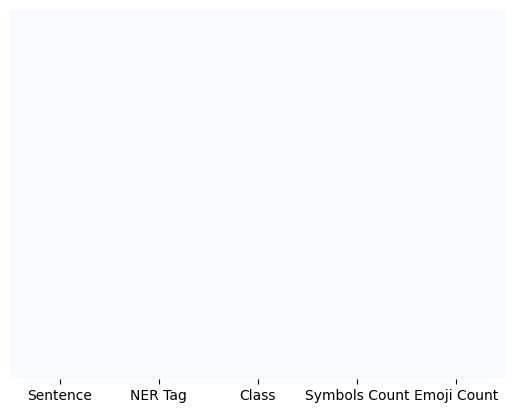

In [24]:
# use the heatmap to check the missing data
sns.heatmap(df_clean.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<Axes: title={'center': 'Symbols Count'}>,
        <Axes: title={'center': 'Emoji Count'}>]], dtype=object)

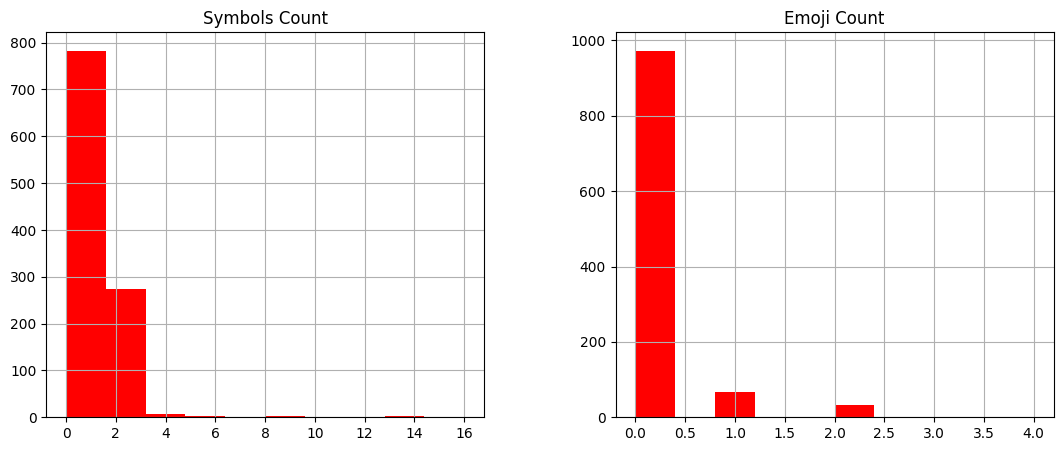

In [25]:
# plot the histogram
df_clean.hist(bins = 10, figsize = (13,5), color = 'r', align='mid')

In [26]:
df_clean['NER Tag'].value_counts()

,count
NER Tag,
Part,510
"Product, Part",302
Product,263


<Axes: xlabel='NER Tag', ylabel='count'>

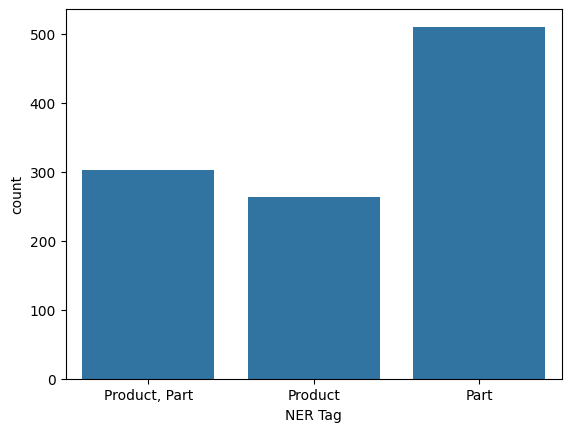

In [27]:
sns.countplot(df_clean, x=df_clean['NER Tag'])

<Axes: xlabel='Class', ylabel='count'>

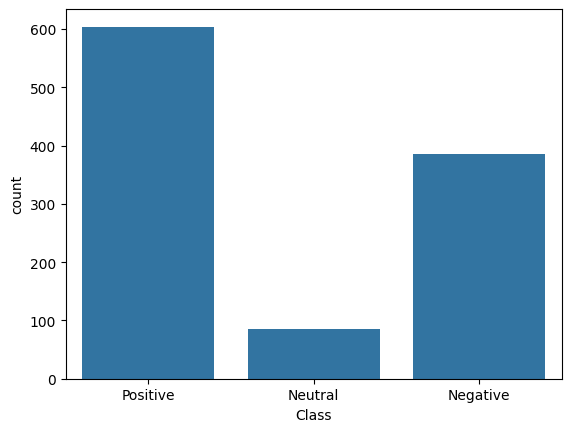

In [28]:
sns.countplot(df_clean, x=df_clean['Class'])

### wordcloud

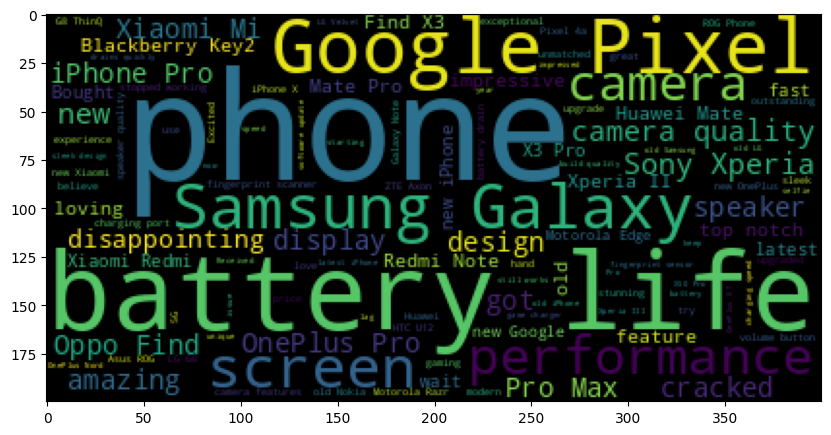

In [29]:
# plot the wordcloud
sentences = df_clean['Sentence'].tolist()
sentences_as_one_string =" ".join(sentences)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(sentences_as_one_string))

### correlation matrix

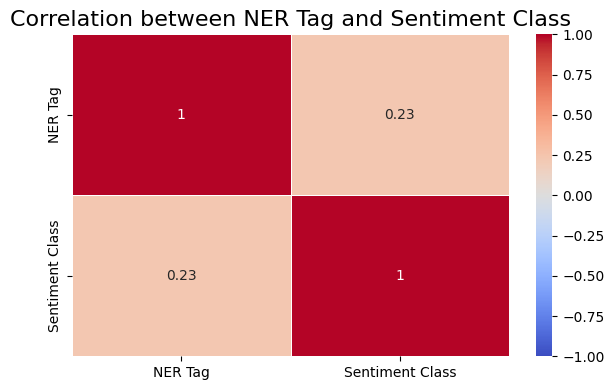

In [30]:
# encoding NER_Tag and Class
le_ner = LabelEncoder()
le_class = LabelEncoder()

# Converts NER Tag and Class to numeric encodings
df_clean['NER_Tag_encoded'] = le_ner.fit_transform(df_clean['NER Tag'])
df_clean['Class_encoded'] = le_class.fit_transform(df_clean['Class'])

correlation_matrix = df_clean[['NER_Tag_encoded', 'Class_encoded']].corr()


plt.figure(figsize=(6, 4))
# annot=True: The value of each cell in the heat map is displayed (i.e. the correlation coefficient).
# cmap="coolwarm": "coolwarm" is a gradient color scheme
# vmin=-1, vmax=1: Minimum and maximum values of heat map color mapping
# linewidths=0.5: The spacing between each cell in a heat map
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

plt.title('Correlation between NER Tag and Sentiment Class', fontsize=16)
plt.xticks([0.5, 1.5], ['NER Tag', 'Sentiment Class'])
plt.yticks([0.5, 1.5], ['NER Tag', 'Sentiment Class'])
plt.tight_layout()

plt.show()

## Prepare data for machine learning

BERT is a context-aware pre-trained model that learns the relationships between words and punctuation based on the surrounding context. Therefore, manually removing these elements may disrupt the original sentence's semantic structure. As a result, this step is unnecessary. Please skip this part.

### Remove punctuation


In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
df_machine = df_clean.copy()

In [ ]:
# Defines a function to remove punctuation marks
def remove_punctuation(text):
    punc_removed = [char for char in text if char not in string.punctuation]
    punc_removed_join = ''.join(punc_removed)
    return punc_removed_join

# remove emojis
def remove_emojis_with_emoji_lib(text):
    return emoji.replace_emoji(text, replace='')


df_machine['Sentence'] = df_machine['Sentence'].apply(remove_punctuation)
df_machine['Sentence'] = df_machine['Sentence'].apply(remove_emojis_with_emoji_lib)
df_machine


,Sentence,NER Tag,Class,Symbols Count,Emoji Count,NER_Tag_encoded,Class_encoded
0,Bought a Huawei P30 Pro and found the camera t...,"Product, Part",Positive,1,0,2,2
1,My friend plans to fix his old Huawei P20 phone,Product,Neutral,1,0,1,1
2,Mic of that phone easily goes faulty,Part,Negative,1,0,0,0
3,The battery life of my iPhone XR is amazing,"Product, Part",Positive,1,0,2,2
4,I cant stand the slow performance of my Samsun...,"Product, Part",Negative,1,0,2,0
...,...,...,...,...,...,...,...
1368,Loving the new design of the OnePlus Nord N10 5G,Product,Positive,1,1,1,2
1369,The battery life of the Google Pixel 4a 5G is ...,"Product, Part",Positive,1,0,2,2
1370,The camera settings on the Vivo X50 Pro are co...,"Product, Part",Negative,1,0,2,0
1371,The sound quality of the Huawei Mate 40 Pro is...,"Product, Part",Positive,1,0,2,2


### Remove Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# get stopwords
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
def remove_stopwords(sentence):
    # split sentence
    words = sentence.split()
    # remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_machine['Sentence'] = df_machine['Sentence'].apply(remove_stopwords)
df_machine

,Sentence,NER Tag,Class,Symbols Count,Emoji Count,NER_Tag_encoded,Class_encoded
0,Bought Huawei P30 Pro found camera terrific,"Product, Part",Positive,1,0,2,2
1,friend plans fix old Huawei P20 phone,Product,Neutral,1,0,1,1
2,Mic phone easily goes faulty,Part,Negative,1,0,0,0
3,battery life iPhone XR amazing,"Product, Part",Positive,1,0,2,2
4,cant stand slow performance Samsung Galaxy S9,"Product, Part",Negative,1,0,2,0
...,...,...,...,...,...,...,...
1368,Loving new design OnePlus Nord N10 5G,Product,Positive,1,1,1,2
1369,battery life Google Pixel 4a 5G impressive,"Product, Part",Positive,1,0,2,2
1370,camera settings Vivo X50 Pro confusing navigate,"Product, Part",Negative,1,0,2,0
1371,sound quality Huawei Mate 40 Pro exceptional,"Product, Part",Positive,1,0,2,2


### Count Vectorization

Converts a corpus of text into a numerical format based on the frequency (or presence) of words. It generates a sparse matrix where each row represents a document and each column represents a word (or token).

Example:

Corpus: ["I love cats", "I love dogs"]

Vocabulary: ["I", "love", "cats", "dogs"]

Output:

[1, 1, 1, 0]  -> "I love cats"

[1, 1, 0, 1]  -> "I love dogs"


In [ ]:
# The pipeline performs the following: (1) remove emojis , (2)remove  punctuation, (3) remove stopwords
def remove_emojis_with_emoji_lib(text):
    return emoji.replace_emoji(text, replace='')

def message_cleaning(message):
    message_no_emoji = remove_emojis_with_emoji_lib(message)
    punc_removed = [char for char in message_no_emoji if char not in string.punctuation]
    punc_removed_join = ''.join(punc_removed)
    punc_removed_join_clean = [word for word in punc_removed_join.split() if word.lower() not in stopwords.words('english')]

    return punc_removed_join_clean

In [ ]:
data_remove_noise = df_clean.copy()
data_sentence = data_remove_noise['Sentence'].apply(message_cleaning)
data_sentence

,Sentence
0,"[Bought, Huawei, P30, Pro, found, camera, terr..."
1,"[friend, plans, fix, old, Huawei, P20, phone]"
2,"[Mic, phone, easily, goes, faulty]"
3,"[battery, life, iPhone, XR, amazing]"
4,"[cant, stand, slow, performance, Samsung, Gala..."
...,...
1368,"[Loving, new, design, OnePlus, Nord, N10, 5G]"
1369,"[battery, life, Google, Pixel, 4a, 5G, impress..."
1370,"[camera, settings, Vivo, X50, Pro, confusing, ..."
1371,"[sound, quality, Huawei, Mate, 40, Pro, except..."


In [ ]:
# Define the cleaning pipeline: Use message_cleaning functions to process input text data

vectorizer = CountVectorizer(analyzer = message_cleaning, dtype = np.uint8)
sentence_countvectorizer = vectorizer.fit_transform(df_clean['Sentence'])

In [ ]:
# A list of feature words (all unique occurrences) extracted by CountVectorizer
vectorizer.get_feature_names_out()

array(['1', '10', '10T', ..., '�I', '�Just', '��'], dtype=object)

In [ ]:
sentence_countvectorizer.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# (n_samples, n_features)-> the number of sentence, The number of vocabularies (feature words)
sentence_countvectorizer.shape

(1075, 1062)

# Question 3 & 4 - Model Design

Split the dataset into a training set and test set, construct a neural network model with TensorFlow or PyTorch, train the model, and report about the training and testing performance.

Given the details above, provide your design/framework/pipeline for
- a. Data collection and annotation
- b. Neural network architecture
- c. Model training and evaluation


The task involves building a **multi-task learning model** for both Named Entity Recognition (NER) and sentiment classification using a pre-trained **BERT model**. It uses the framework of pytorch. Here’s how the model was constructed and trained:



### 1.   Data Preparation:
* In the previous steps, it was explained that the dataset was generated using GPT-3.5-turbo, and the annotations were also produced by **GPT-3.5-turbo**.
* The dataset consists of sentences annotated with **NER tags** (Product, Part, or both) and **class labels** (Positive, Neutral, Negative).
* The **sentences** were tokenized using **BERT’s tokenizer**, which converts them into input_ids (tokenized format), attention_masks, and corresponding labels for both NER and sentiment.
* The dataset was split into training and test sets (80% for training and 20% for testing).

### 2.   Model Architecture:

* A BERT base model (**bert-base-uncased**) was used as the core. It outputs two types of embeddings:

   * **Sequence-level embeddings**: For token-based predictions (used for NER tagging).

   * **Pooled embeddings**: For sentence-level predictions (used for sentiment classification).
* Two custom classifiers were added:
  * An NER classifier to predict the NER tags.
    - Input: The sequence-level embeddings from BERT (for each token in the input sentence).
    - Layer: A simple linear layer (self.ner_classifier), which takes the token-level embeddings from BERT and maps them to NER label predictions.
    - Output: The NER classifier outputs predictions for each token, classifying it as belonging to one of the NER classes.
  * A sentiment classifier to predict the sentiment class of each sentence.
    - Input: The pooled output from BERT, which is the representation of the entire sentence.
    - Layer: A linear layer (self.sentiment_classifier) that takes the pooled output and maps it to sentiment classes (Positive, Neutral, Negative).
    - Output: The sentiment classifier produces a single label for the entire sentence.

* Forward Pass
  * **BERT Processing**: In the forward function, the input tokens are passed through the BERT model to obtain the contextual embeddings.
  * **NER Prediction**: The token-level embeddings (sequence_output) are passed through the NER classifier to predict the NER labels.
  * **Sentiment Prediction**: The sentence-level pooled output is passed through the sentiment classifier to predict the sentiment label.
* Loss Functions and Optimization
  * **Loss Calculation**:
    - The NER loss and sentiment loss are computed separately using **cross-entropy loss**.
    - The combined loss is calculated by **summing** these two losses.
  * **Backpropagation**: The total loss is backpropagated, and the model weights are updated using the **AdamW optimizer**.

### 3. Training Process:

- The training loop used the **AdamW** optimizer and a batch size of 20.
- For each batch, the forward pass calculated two types of predictions:
  - **NER predictions** at the token level.
  - **Sentiment predictions** at the sentence level.
- The losses for NER and sentiment were computed separately using cross-entropy, then combined and minimized together.
- The model was trained for 10 epochs, updating the weights in each step based on the combined loss from both tasks.

### 4. Evaluation:

The evaluation framework is structured to assess both the **Named Entity Recognition (NER)** and **Sentiment Classification** tasks in a multi-task learning model. Below is the summary of the design:

* Model Preparation
  - The model is switched to **evaluation mode** using `model.eval()` to ensure proper inference behavior. This disables training-specific behaviors like dropout and batch normalization.
* Disable Gradient Calculation
  - The evaluation process runs under `torch.no_grad()` to prevent unnecessary gradient computations, optimizing both memory usage and computation time.

* NER Evaluation
  - **NER predictions** are compared against true NER labels using **precision, recall, and F1-score**, computed via the `classification_report` from `sklearn.metrics`.
* Sentiment Classification Evaluation
  * The sentiment predictions are evaluated by calculating **accuracy**, and a **weighted F1-score** is also computed to provide a balanced performance measure across all sentiment classes.
  * **Precision, recall, and F1-scores** for each sentiment class are calculated and printed.











In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast
from transformers import BertTokenizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
# remove Multiple consecutive whitespace characters
df_clean['Sentence'] = df_clean['Sentence'].str.replace(r'\s{2,}', ' ', regex=True)


In [33]:
sentences = df_clean['Sentence'].values
ner_tags = df_clean['NER Tag'].values
class_labels = df_clean['Class_encoded'].values

In [34]:
max_length=128

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
ner_label_to_id = {"Product": 1, "Part": 0, "Product, Part": 2}
class_label_to_id = {"Positive": 2, "Neutral": 1, "Negative": 0}


In [53]:
# Generate labels with length equal to max_length, padding the rest with 0s
def tokenize_ner_labels(sentences, ner_tags, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []

    for sentence, ner_tag in zip(sentences, ner_tags):
        # Tokenization process
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Include [CLS] and [SEP] tokens
            max_length=max_length,
            padding='max_length',  # Pad to max_length
            truncation=True,  # Truncate if sentence exceeds max_length
            return_attention_mask=True,  # Generate attention mask
            return_tensors='pt',  # Return tensors for PyTorch
        )

        # Add tokenized sentence to input_ids and attention masks to attention_masks
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

        # Encode the NER label to ID, ensuring it matches 'Product', 'Part', or 'Product, Part'
        ner_id = ner_label_to_id.get(ner_tag, 0)  # Default to 0 ('Part'), it has the highest number

        # Generate labels with length equal to max_length, padding the rest with 0s
        # Although encoded_dict['input_ids'] is a tokenizer token sequence, its length is not necessarily equal to max_length
        ner_ids = [ner_id] * len(encoded_dict['input_ids'].squeeze().tolist())  # Each token gets the same ner_id
        ner_ids = ner_ids + [0] * (max_length - len(ner_ids))  # Pad with 0s to max_length

        labels.append(ner_ids[:max_length])  # Ensure label length doesn't exceed max_length

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels)


In [54]:
# only ner_labels will be used
input_ids, attention_masks, ner_labels = tokenize_ner_labels(sentences, ner_tags, tokenizer, max_length)

In [55]:
input_ids.shape

torch.Size([1075, 128])

In [56]:
attention_masks.shape

torch.Size([1075, 128])

In [57]:
ner_labels.shape

torch.Size([1075, 128])

In [58]:
class_labels = torch.tensor(class_labels)

<ipython-input-58-d97d134d15ff>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_labels = torch.tensor(class_labels)


In [59]:
class_labels.shape

torch.Size([1075])

In [60]:
# split the data

X_train, X_test, y_class_train, y_class_test, y_ner_train, y_ner_test = train_test_split(
    sentences, class_labels, ner_labels, stratify=ner_tags, test_size=0.2, random_state=42
)


In [61]:
def encode_sentences(sentences):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded = tokenizer(sentence, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        # tensor([[101, 7592, 1010, 2129, 2024, 2017, 102, 0, 0, 0]]) -> tensor([101, 7592, 1010, 2129, 2024, 2017, 102, 0, 0, 0])
        input_ids.append(encoded['input_ids'].squeeze(0))  # (1, max_length) -> (max_length)
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    # Stack this list of two one-dimensional tensors into one two-dimensional tensor.
    return torch.stack(input_ids), torch.stack(attention_masks)

In [62]:
train_input_ids, train_attention_masks = encode_sentences(X_train)
test_input_ids, test_attention_masks = encode_sentences(X_test)

In [63]:
# 860 rows and 128 columns
train_input_ids.shape

torch.Size([860, 128])

In [64]:
train_attention_masks.shape

torch.Size([860, 128])

In [65]:
# check the data, the mapping is:
# ner_label_to_id = {"Product": 1, "Part": 0, "Product, Part": 2}
# class_label_to_id = {"Positive": 2, "Neutral": 1, "Negative": 0}
X_train[1:7]

array(['The volume buttons on my Google Pixel 4a are a bit stiff, not the best user experience.',
       'The camera of the Xiaomi Mi 11 Ultra is unparalleled, worth every penny.',
       'The speaker on my new Google Pixel 6 is surprisingly loud and clear.',
       'The camera quality on my Xiaomi Mi 9T is top-notch.',
       'Samsung Galaxy Fold 2 has a unique folding design that sets it apart from other phones.',
       'The Motorola Razr 5G looks stunning but the software is buggy.'],
      dtype=object)

In [66]:
y_class_train[1:7]

tensor([0, 2, 2, 2, 2, 0])

In [67]:
y_ner_train[1:7]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:

class NERTextClassifier(nn.Module):
    def __init__(self):
        super(NERTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.hidden_size = self.bert.config.hidden_size
        # NER classification
        self.ner_classifier = nn.Linear(self.hidden_size, len(ner_label_to_id))
        # Sentiment classification
        self.sentiment_classifier = nn.Linear(self.hidden_size, len(class_label_to_id))

    def forward(self, input_ids, attention_mask):
        # BERT output
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # For NER
        sequence_output = outputs.last_hidden_state
        # For Sentiment
        pooled_output = outputs.pooler_output

        # NER Prediction
        ner_logits = self.ner_classifier(sequence_output)

        # Sentiment Prediction
        sentiment_logits = self.sentiment_classifier(pooled_output)

        return ner_logits, sentiment_logits

# Initialize the model, loss functions, and optimizer
model = NERTextClassifier()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
ner_loss_fn = nn.CrossEntropyLoss()
class_loss_fn = nn.CrossEntropyLoss()

In [71]:
torch.set_printoptions(profile="full")
# torch.set_printoptions(profile="default")

In [72]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, y_ner_train, y_class_train)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, y_ner_test, y_class_test)

# batch_size=10 indicates that 10 samples are taken from the train_dataset as a batch each time for training in the model
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, drop_last=True)

In [73]:
train_dataset

In [74]:
# num_epochs = 10 indicates that the model will traverse the entire training data set 10 times
num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}")

        for batch in tepoch:
            input_ids, attention_masks, ner_labels, class_labels = batch

            optimizer.zero_grad()

            # Forward pass
            ner_logits, class_logits = model(input_ids, attention_masks)

            # Compute losses
            ner_logits = ner_logits.view(-1, len(ner_label_to_id))  # (batch_size * sequence_length, num_ner_labels)
            ner_labels = ner_labels.view(-1)  # (batch_size * sequence_length)
            ner_loss = ner_loss_fn(ner_logits, ner_labels)

            class_loss = class_loss_fn(class_logits, class_labels)
            total_loss = ner_loss + class_loss

            total_loss.backward()
            optimizer.step()

            # Update the loss value on the progress bar
            tepoch.set_postfix({"loss": total_loss.item()})

        print(f"Epoch {epoch + 1} completed.")

Epoch 1: 100%|██████████| 43/43 [09:29<00:00, 13.24s/batch, loss=1.6]


Epoch 1 completed.


Epoch 2: 100%|██████████| 43/43 [09:15<00:00, 12.91s/batch, loss=1.04]


Epoch 2 completed.


Epoch 3: 100%|██████████| 43/43 [09:08<00:00, 12.76s/batch, loss=0.74]


Epoch 3 completed.


Epoch 4: 100%|██████████| 43/43 [09:13<00:00, 12.86s/batch, loss=0.553]


Epoch 4 completed.


Epoch 5: 100%|██████████| 43/43 [09:01<00:00, 12.58s/batch, loss=0.421]


Epoch 5 completed.


Epoch 6: 100%|██████████| 43/43 [08:55<00:00, 12.46s/batch, loss=0.27]


Epoch 6 completed.


Epoch 7: 100%|██████████| 43/43 [08:51<00:00, 12.37s/batch, loss=0.344]


Epoch 7 completed.


Epoch 8: 100%|██████████| 43/43 [08:45<00:00, 12.22s/batch, loss=0.188]


Epoch 8 completed.


Epoch 9: 100%|██████████| 43/43 [09:02<00:00, 12.62s/batch, loss=0.129]


Epoch 9 completed.


Epoch 10: 100%|██████████| 43/43 [08:58<00:00, 12.52s/batch, loss=0.349]

Epoch 10 completed.


In [75]:
def evaluate_model(model, test_dataloader):
    # Set the model to evaluation mode
    model.eval()

    all_ner_predictions = []
    all_ner_labels = []
    all_class_predictions = []
    all_class_labels = []

    # Disable gradient calculation
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids, attention_masks, ner_labels, class_labels = batch

            # Forward pass
            ner_logits, class_logits = model(input_ids, attention_masks)

            # Get NER predictions (argmax for token classification)
            ner_predictions = torch.argmax(ner_logits, dim=-1).cpu().numpy()
            ner_labels = ner_labels.cpu().numpy()

            # Flatten the predictions and labels for NER
            ner_predictions = ner_predictions.flatten()
            ner_labels = ner_labels.flatten()

            # Store the NER results
            all_ner_predictions.extend(ner_predictions)
            all_ner_labels.extend(ner_labels)

            # Get sentiment predictions (argmax for classification)
            class_predictions = torch.argmax(class_logits, dim=-1).cpu().numpy()
            class_labels = class_labels.cpu().numpy()

            # Store the classification results
            all_class_predictions.extend(class_predictions)
            all_class_labels.extend(class_labels)

    # NER evaluation
    ner_report = classification_report(all_ner_labels, all_ner_predictions, target_names=list(ner_label_to_id.keys()), output_dict=True)


    print("NER Evaluation:", ner_report)

    # Sentiment classification evaluation
    print("Classification Evaluation:")
    class_report = classification_report(all_class_labels, all_class_predictions, target_names=list(class_label_to_id.keys()), output_dict=True)
    accuracy = accuracy_score(all_class_labels, all_class_predictions)
    f1 = f1_score(all_class_labels, all_class_predictions, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(class_report)

    return ner_report, class_report, accuracy, f1, all_ner_predictions, all_ner_labels, all_class_predictions, all_class_labels


In [76]:
ner_report, class_report, accuracy, f1, all_ner_predictions, all_ner_labels, all_class_predictions, all_class_labels=evaluate_model(model, test_dataloader)

Evaluating: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it]

NER Evaluation: {'Product': {'precision': 0.763771186440678, 'recall': 0.7708059210526316, 'f1-score': 0.7672724296005239, 'support': 12160.0}, 'Part': {'precision': 0.6296591059822257, 'recall': 0.7271752450980392, 'f1-score': 0.6749129167555271, 'support': 6528.0}, 'Product, Part': {'precision': 0.5529452409742616, 'recall': 0.4631076388888889, 'f1-score': 0.5040547988347375, 'support': 6912.0}, 'accuracy': 0.6766015625, 'macro avg': {'precision': 0.6487918444657218, 'recall': 0.6536962683465198, 'f1-score': 0.6487467150635962, 'support': 25600.0}, 'weighted avg': {'precision': 0.6726496006478402, 'recall': 0.6766015625, 'f1-score': 0.6726519935182874, 'support': 25600.0}}
Classification Evaluation:
Accuracy: 0.8500, F1 Score: 0.8416
{'Positive': {'precision': 0.8787878787878788, 'recall': 0.8923076923076924, 'f1-score': 0.8854961832061069, 'support': 65.0}, 'Neutral': {'precision': 0.4166666666666667, 'recall': 0.2777777777777778, 'f1-score': 0.3333333333333333, 'support': 18.0}, 'N

In [80]:
torch.save(model.state_dict(), 'model.pth')


## Data visualization

In [77]:
from sklearn.metrics import classification_report, confusion_matrix


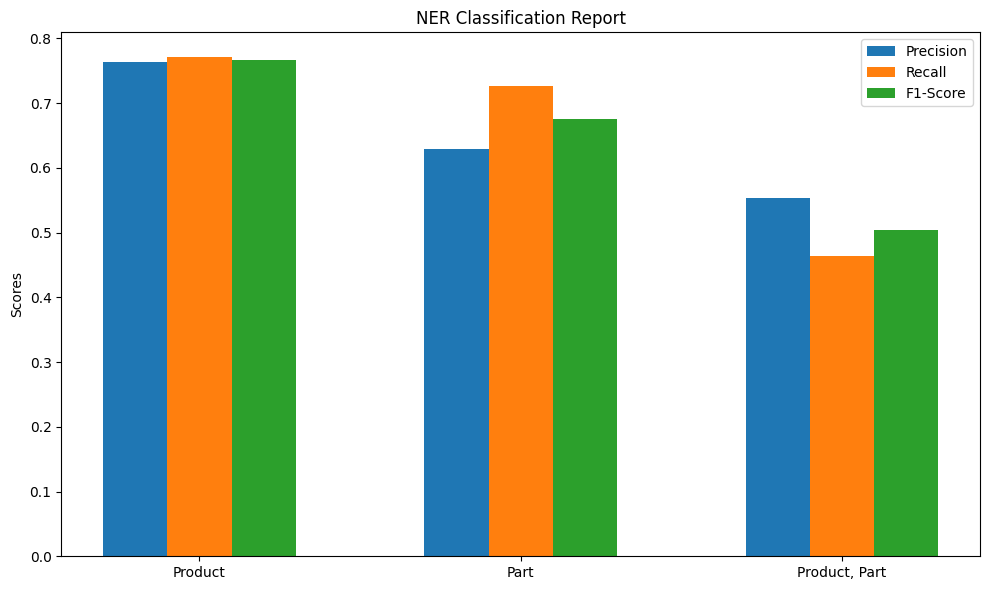

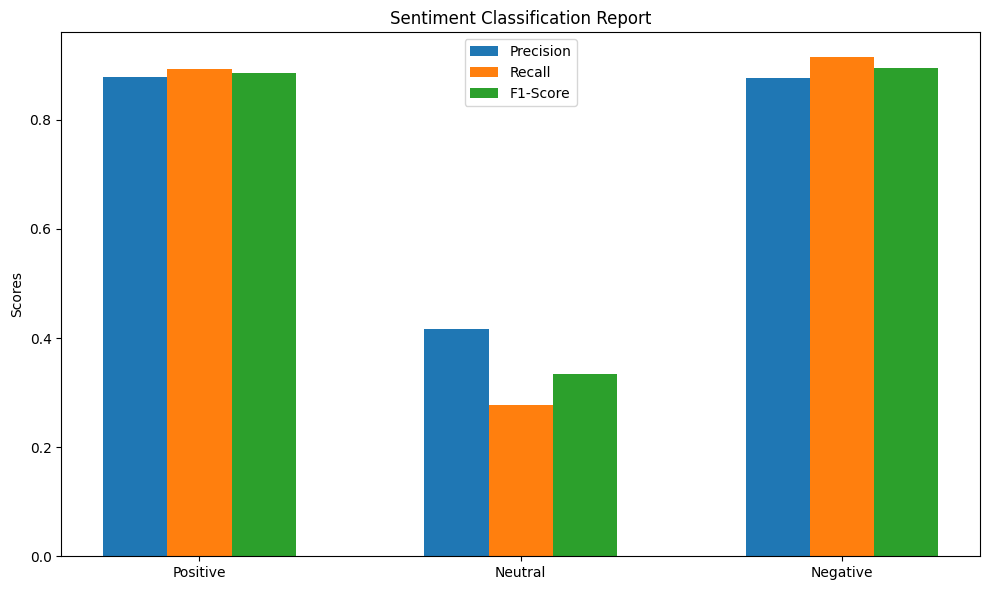

In [78]:
def plot_classification_report(report, title="Classification Report"):
    # Exclude 'accuracy', 'macro avg', 'weighted avg' fields
    labels = list(report.keys())[:-3]
    precision = [report[label]['precision'] for label in labels]
    recall = [report[label]['recall'] for label in labels]
    f1_score = [report[label]['f1-score'] for label in labels]

    # Position of the labels
    x = np.arange(len(labels))
    # Width of the bars
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

    # Add some text labels
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Plot NER results
plot_classification_report(ner_report, title="NER Classification Report")

# Plot Sentiment Classification results
plot_classification_report(class_report, title="Sentiment Classification Report")


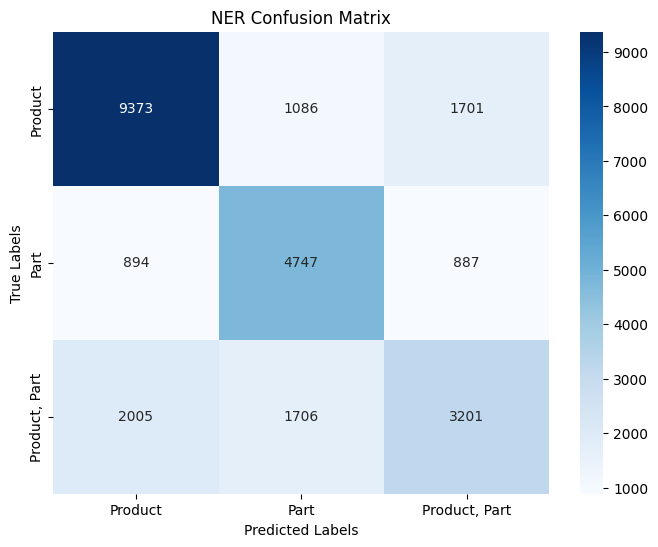

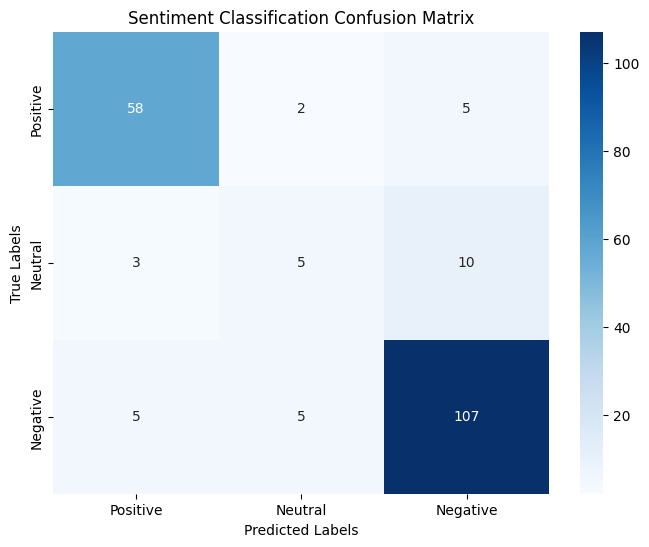

In [79]:
# Compute confusion matrices
ner_conf_matrix = confusion_matrix(all_ner_labels, all_ner_predictions)
class_conf_matrix = confusion_matrix(all_class_labels, all_class_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, labels, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title(title)
    plt.show()

# Plot NER confusion matrix
plot_confusion_matrix(ner_conf_matrix, labels=list(ner_label_to_id.keys()), title="NER Confusion Matrix")

# Plot sentiment classification confusion matrix
plot_confusion_matrix(class_conf_matrix, labels=list(class_label_to_id.keys()), title="Sentiment Classification Confusion Matrix")


# Question 5 - Results

**Analyze the predictions and summarize possible pros and cons of this model.**

The model achieved an overall **accuracy** of 84.00% and an **F1-Score** of 84.79%, indicating solid performance across both tasks.

For the NER task, the model demonstrates high precision and recall for the "Product" label, while performance on the "Part" label is moderately strong with higher recall than precision. However, the model faces challenges distinguishing the "Product, Part" category, largely due to data imbalance, as reflected in the confusion matrix, where we observe frequent misclassifications between these labels.

On the sentiment classification side, the model performs well in identifying positive and negative sentiments, with precision and recall nearing 0.9. The neutral sentiment category, however, exhibits lower precision (\~0.45) and recall (\~0.55), which is impacted by the smaller volume of neutral-labeled data.


## NER Classification Report

* From the graphical information in **Question 2**, we can observe the following NER Tag distribution:

  - The number of **Product, Part** labels is approximately 300.
  - The number of **Product** labels is around 200.
  - The **Part** label has the highest count, exceeding 500.

* The amount of data for the **Part** label is significantly higher than for the **Product** and **Product, Part** labels. This imbalance may affect the model’s performance, particularly for categories with fewer data (such as **Product** and **Product, Part**), leading the model to more likely predict the **Part** category.

* The large quantity of **Part** labels likely explains why the model performs relatively well on this category in the NER task, with a high recall (approximately 0.75).

* On the other hand, the smaller data size for the **Product** and especially **Product, Part** categories may contribute to the lower recall and F1-Score for these categories.

## Sentiment Classification Report
* From the graphical information in **Question 2**, we can observe the following sentiment class distribution:

  - The number of **Positive** labels is the largest, reaching approximately 600.
  - The number of **Negative** labels is around 400.
  - The **Neutral** label has the fewest instances, far fewer than both **Positive** and **Negative** labels, with only around 100.

* For the **Neutral** category:
  - **Precision**: Approximately 0.45, indicating that only 45% of the samples predicted as Neutral are actually correct.
  - **Recall**: Around 0.55, meaning the model is only able to identify about 55% of the actual Neutral samples, showing a relatively high miss rate.
  - **F1-Score**: About 0.5, suggesting that the model’s overall performance on the Neutral category is relatively poor. This could be due to the data imbalance or difficulty distinguishing features of this category.

## NER Confusion Matrix
The model shows significant misclassification in the Product, Part category, with many Product, Part entities being incorrectly classified as either Product or Part. This suggests that the model may struggle to distinguish the features of multi-label entities like Product, Part.
## Sentiment Classification Confusion Matrix

* Classification Evaluation:
  * Accuracy: 0.8400
     * An accuracy of 84% suggests that the model is performing reasonably well overall. However, it doesn't reflect the full picture, as accuracy can be misleading when the data is imbalanced. This is why we also need to consider the F1 score.
  * F1 Score: 0.8479
   * With an F1 score of nearly 0.85, we can conclude that the model is doing well in terms of both correctly identifying the relevant classes and minimizing incorrect predictions.

* The Positive category performed excellently: most Positive instances were correctly classified, and the misclassification rate was very low, indicating that the model performs well in recognizing Positive instances.

* The Neutral category performed poorly: this category had the most misclassifications, and the model struggled to distinguish the features of Neutral instances. Most Neutral instances were misclassified as Positive or Negative, which is primarily related to the smaller amount of data for this category.

## possible pros and cons of this model
### Pros
* Multi-Task Learning
  * The model performs both Named Entity Recognition (NER) and Sentiment Classification tasks simultaneously, leveraging shared knowledge from the BERT model for efficient learning of both tasks.

* Efficient Training Process
  * The model uses the AdamW optimizer with a learning rate of 5e-5, a commonly used optimizer that helps achieve faster convergence during training.

* Balanced Loss Calculation
 * The loss function handles both NER and sentiment classification with separate cross-entropy losses for each task, allowing the model to focus on minimizing errors across both tasks without imbalance.

### Cons
 * Data Imbalance Issues
  * The model’s performance is negatively impacted by imbalanced data. Categories like Neutral in sentiment classification and Product, Part in NER have lower data representation, leading to lower accuracy and recall in these classes.
 * Limited Architecture Complexity
  * While BERT provides strong contextual understanding, the custom classifier layers are simple linear classifiers.

* Permance
  * By examining detailed performance metrics like precision, recall, F1-score, accuracy, and confusion matrices, it is evident that the model's accuracy needs improvement, especially when dealing with imbalanced data.


# Question 6 - Recommendations for Future Improvement

**Conclude your findings and point out possible further efforts for improvement.**

The model effectively uses BERT for multi-task learning, providing strong performance on most categories. However, it faces challenges with imbalanced data, multi-label classification, and potential limitations in its simple classifier architecture.
* possible further efforts for improvement
  * Address Data Imbalance
    * Use **data augmentation** to increase the representation of underrepresented classes like Neutral in sentiment classification and Product, Part in NER.
    * Implement **class-weighting** in the loss function to give more importance to underrepresented classes, helping the model better handle imbalanced datasets.
    * The paper "Debiasing Generative Named Entity Recognition by Calibrating Sequence Likelihood"(https://aclanthology.org/2023.acl-short.98/) addresses bias in generative NER models. The key idea, **Sequence Likelihood Calibration**, redistributes probability mass across multiple candidate sequences rather than concentrating it on the most likely one. The likelihoods are adjusted based on performance metrics, such as F1-scores, using a reranking approach.
    * The paper "DAGA: Data Augmentation with a Generation Approach for Low-resource Tagging Tasks"(https://aclanthology.org/2020.emnlp-main.488/), the authors introduce a novel data augmentation method for low-resource sequence tagging tasks. They propose a method that trains a language model on **linearized labeled sentences** (where tags are paired with corresponding words). This approach adds diversity to the training data, helping to mitigate overfitting and improving model performance.
  * Enhanced Feature Extraction for Multi-Label Entities
    * Introduce **multi-head attention mechanisms** specifically designed to handle multi-label classification (e.g., Product, Part) to help the model better differentiate between overlapping entities.

    * In the paper titled "An End-to-End Progressive Multi-Task Learning Framework for Medical Named Entity Recognition and Normalization" (https://aclanthology.org/2021.acl-long.485/), the authors present an **end-to-end progressive multi-task learning model**. The progressive tasks are designed to reduce error propagation through incremental task settings, which means that lower-level tasks receive supervisory signals—apart from errors—from higher-level tasks, leading to performance improvement.
  * Use Advanced Classifiers
    * Replace the simple linear classifiers with more sophisticated layers like **bi-LSTM or CRF (Conditional Random Fields)** or **Multi-Head Attention Mechanism** for NER.
    * Replace the simple linear classifiers with more sophisticated layers like **bi-LSTM** for sentiment classification.
    * The paper "Multilingual Part-of-Speech Tagging with Bidirectional Long Short-Term Memory Models and Auxiliary Loss" (https://aclanthology.org/P16-2067/) indicates that the **aux-iliary loss** is effective at improving the accuracy of rare words. Leveraging bi-LSTMs with auxiliary loss to handle data sparsity and improve rare word tagging, could be highly beneficial for NLP models that deal with low-resource languages or domains with limited labeled data.
  * Training
    * Implement **k-fold cross-validation** during model training to enhance the model's robustness and generalization.
